In [1]:
import numpy as np
import pickle
from itertools import chain
from sklearn.model_selection import train_test_split
import matplotlib.pylab as plt
import itertools
from copy import deepcopy
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.utils.data as data_utils

import sys, os
try:
    %matplotlib inline
    sys.path.append(os.path.join(os.path.dirname("__file__"), '..', '..', '..'))
    from AI_scientist.settings.filepath import variational_model_PATH, dataset_PATH
    isplot = True
except:
    sys.path.append(os.path.join(os.path.dirname(__file__), '..', '..', '..'))
    from AI_scientist.settings.filepath import variational_model_PATH, dataset_PATH
    if dataset_PATH[:2] == "..":
        dataset_PATH = dataset_PATH[3:]
    isplot = False

from AI_scientist.util import plot_matrices, make_dir, get_struct_str, get_args, Early_Stopping, record_data, manifold_embedding
from AI_scientist.pytorch.modules import Simple_Layer
from AI_scientist.pytorch.net import Net, ConvNet
from AI_scientist.pytorch.util_pytorch import Loss_with_uncertainty, get_criterion, to_np_array, get_optimizer
from AI_scientist.variational.util_variational import get_torch_tasks
from AI_scientist.variational.variational_meta_learning import Master_Model, Statistics_Net, Generative_Net, load_model_dict, get_regulated_statistics
from AI_scientist.variational.variational_meta_learning import VAE_Loss, sample_Gaussian, clone_net, get_nets, get_tasks, evaluate, get_reg, load_trained_models
from AI_scientist.variational.variational_meta_learning import forward, get_forward_pred, get_rollout_pred_loss, get_autoencoder_losses, Loss_with_autoencoder
from AI_scientist.variational.variational_meta_learning import plot_task_ensembles, plot_individual_tasks, plot_statistics_vs_z, plot_data_record, get_corrcoef
from AI_scientist.variational.variational_meta_learning import plot_few_shot_loss, plot_individual_tasks_bounce, quick_learn
from AI_scientist.variational.variational_meta_learning import get_latent_model_data, get_polynomial_class, get_Legendre_class, get_master_function

seed = 1
np.random.seed(seed)
torch.manual_seed(seed)
is_cuda = torch.cuda.is_available()
is_cuda = False
print("is_cuda: {0}".format(is_cuda))

is_cuda: False


In [2]:
def combine_dataset(tasks, num = None):
    X_train_list = []
    y_train_list = []
    X_test_list = []
    y_test_list = []
    num_examples_select = 100
    for i, task in enumerate(tasks.values()):
        if num is not None and i > num:
            break
        ((X_train, y_train), (X_test, y_test)), info = task
        X_train_list.append(X_train[:num_examples_select])
        y_train_list.append(y_train[:num_examples_select])
        X_test_list.append(X_test[:num_examples_select])
        y_test_list.append(y_test[:num_examples_select])
    X_train_all = torch.cat(X_train_list)
    y_train_all = torch.cat(y_train_list)
    X_test_all = torch.cat(X_test_list)
    y_test_all = torch.cat(y_test_list)
    return (X_train_all, y_train_all), (X_test_all, y_test_all)

def plot_encoding(X, autoencoder, target = "encoding"):
    axis_list = []
    X = X.data
    X = X[:200]
    for i in range(len(X)):
        data = X[i]
        row, column = data.squeeze().nonzero().float().mean(0)
        axis_list.append([row, column])
    axis_list = np.array(axis_list)
    encoding = autoencoder.encode(Variable(X)).cpu().data.numpy().astype(float)
    if target == "encoding":
        print("row:")
        plt.scatter(encoding[:,0], encoding[:,1], s = 0.5 + 3 * axis_list[:,0])
        plt.show()
        print("column:")
        plt.scatter(encoding[:,0], encoding[:,1], s = 0.5 + 3 * axis_list[:,1])
        plt.show()
    elif target == "axis":
        print("row:")
        plt.scatter(axis_list[:,0], axis_list[:,1], s = 0.5 + 5 * encoding[:,0])
        plt.show()
        print("column:")
        plt.scatter(axis_list[:,0], axis_list[:,1], s = 0.5 + 5 * encoding[:,1])
        plt.show()


def plot_tasks(tasks, master_model = None, model = None, autoencoder = None, forward_steps = None, num_tasks = 3, oracle_size = None):
    task_keys = np.random.choice(list(tasks.keys()), num_tasks, replace = False)
    for i, task_key in enumerate(task_keys):
        task = tasks[task_key]
        ((X_train_obs, y_train_obs), (X_test_obs, y_test_obs)), z_info = task
        X_train = forward(autoencoder.encode, X_train_obs)
        y_train = forward(autoencoder.encode, y_train_obs[:, forward_steps_idx])
        X_test = forward(autoencoder.encode, X_test_obs)
        y_test = forward(autoencoder.encode, y_test_obs[:, forward_steps_idx])
        if oracle_size is not None:
            z_train = Variable(torch.FloatTensor(np.repeat(np.expand_dims(z_info["z"],0), len(X_train), 0)), requires_grad = False)
            z_test = Variable(torch.FloatTensor(np.repeat(np.expand_dims(z_info["z"],0), len(X_test), 0)), requires_grad = False)
            if X_train.is_cuda:
                z_train = z_train.cuda()
                z_test = z_test.cuda()
            X_train = torch.cat([X_train, z_train], 1)
            X_test = torch.cat([X_test, z_test], 1)  
        
        # Plotting:
        print("Task {0}:".format(task_key))
        plot_matrices(np.concatenate((to_np_array(X_test_obs[0]), to_np_array(y_test_obs)[:, np.array(forward_steps) - 1][0])))
        if master_model is not None:
            statistics = master_model.statistics_Net.forward_inputs(X_train, y_train)
            latent_pred = get_forward_pred(master_model.generative_Net, X_test, forward_steps, is_time_series = True, latent_param = statistics, jump_step = 2, is_flatten = False)
        else:
            latent_pred = get_forward_pred(model, X_test, forward_steps, is_time_series = True, jump_step = 2, is_flatten = False)
        pred_recons = forward(autoencoder.decode, latent_pred)
        if oracle_size is None:
            plot_matrices(np.concatenate((to_np_array(forward(autoencoder.decode, X_test.view(X_test.size(0), -1, 2))[0]), to_np_array(pred_recons[0]))))  
        else:
            plot_matrices(np.concatenate((to_np_array(forward(autoencoder.decode, X_test[:, :-oracle_size].contiguous().view(X_test.size(0), -1, 2))[0]), to_np_array(pred_recons[0]))))  


class Conv_Autoencoder(nn.Module):
    def __init__(
        self,
        encoder_struct_param,
        decoder_struct_param,
        enc_flatten_size = 512,
        latent_size = (1,2),
        settings = {},
        is_cuda = False,
        ):
        super(Conv_Autoencoder, self).__init__()
        self.enc_flatten_size = enc_flatten_size
        self.latent_size = latent_size
        self.encoder = ConvNet(input_channels = 1, struct_param = encoder_struct_param, settings = settings, is_cuda = is_cuda)
        self.decoder = ConvNet(input_channels = encoder_struct_param[-1][0], struct_param = decoder_struct_param, settings = settings, is_cuda = is_cuda)
        self.enc_fully = Simple_Layer(enc_flatten_size, latent_size, settings = {"activation": "linear"}, is_cuda = is_cuda)
        self.dec_fully = Simple_Layer(latent_size, enc_flatten_size, settings = {"activation": "linear"}, is_cuda = is_cuda)
        self.is_cuda = is_cuda
    
    def encode(self, input):
        enc_hidden, _ = self.encoder(input)
        self.enc_hidden_size = enc_hidden.size()[1:]
        enc_flatten = enc_hidden.view(enc_hidden.size(0), -1)
        latent = self.enc_fully(enc_flatten)
        return latent
    
    def decode(self, latent):
        dec_hidden = self.dec_fully(latent).view(-1, *self.enc_hidden_size)
        output, _ = self.decoder(dec_hidden)
        return output
    
    def forward(self, input):
        latent = self.encode(input)
        return self.decode(latent)
    
    def get_regularization(self, source = ["weight", "bias"], mode = "L1"):
        return self.encoder.get_regularization(source = source, mode = mode) + \
                self.decoder.get_regularization(source = source, mode = mode) + \
                self.enc_fully.get_regularization(source = source, mode = mode) + \
                self.dec_fully.get_regularization(source = source, mode = mode)


def train_epoch_pretrain(train_loader, X_test_all, autoencoder, optimizer_pre, isplot = True):
    for batch_id, X_batch in enumerate(train_loader):
        X_batch = Variable(X_batch)
        optimizer_pre.zero_grad()
        reconstruct = forward(autoencoder, X_batch)
        reg = autoencoder.get_regularization(source = ["weight", "bias"]) * reg_amp_autoencoder
        reg_latent = forward(autoencoder, X_batch).mean() * reg_amp_latent
        loss_train = nn.MSELoss()(reconstruct, X_batch) + reg + reg_latent
        loss_train.backward()
        optimizer_pre.step()

    reconstruct_test = forward(autoencoder, X_test_all)
    loss_test = nn.MSELoss()(reconstruct_test, X_test_all)
    to_stop = early_stopping_pre.monitor(loss_test.data[0])
    print("epoch {0} \tloss_train: {1:.6f}\tloss_test: {2:.6f}\treg: {3:.6f}\treg_latent: {4:.6f}".format(epoch, loss_train.data[0], loss_test.data[0], reg.data[0], reg_latent.data[0]))
    if epoch % 10 == 0 and isplot:
        plot_matrices(X_batch[0].cpu().data.numpy(), images_per_row = 5)
        latent = forward(autoencoder.encode, X_batch)
        print("latent: {0}".format(latent.cpu().data.numpy()[0]))
        plot_matrices(reconstruct[0].cpu().data.numpy(), images_per_row = 5)
        plot_encoding(X_train_all[:,:1], autoencoder, "axis")
    return to_stop


def train_epoch_joint(motion_train_loader, X_motion_test, y_motion_test, conv_encoder, predictor, forward_steps, aux_coeff, isplot = True):
    for batch_id, (X_motion_batch, y_motion_batch) in enumerate(motion_train_loader):
        X_motion_batch = Variable(X_motion_batch)
        y_motion_batch = Variable(y_motion_batch)
        optimizer_motion.zero_grad()
        loss_auxiliary, loss_pred_recons, pred_recons_batch = get_losses(conv_encoder, predictor, X_motion_batch, y_motion_batch, forward_steps = forward_steps)
        reg_conv = conv_encoder.get_regularization(source = ["weight", "bias"]) * reg_amp_conv * reg_multiplier[epoch]
        reg_predictor = predictor.get_regularization(source = ["weight", "bias"]) * reg_amp_predictor * reg_multiplier[epoch]
        loss_train = loss_auxiliary * aux_coeff + loss_pred_recons + reg_conv + reg_predictor
        loss_train.backward()
        optimizer_motion.step()

    loss_auxiliary_test, loss_pred_recons_test, pred_recons_test = get_losses(conv_encoder, predictor, X_motion_test, y_motion_test, forward_steps = forward_steps)
    loss_test = loss_auxiliary_test * aux_coeff + loss_pred_recons_test + reg_conv + reg_predictor
    to_stop = early_stopping_motion.monitor(loss_test.data[0])
    print("epoch {0}\tloss_train: {1:.6f}\tloss_test: {2:.6f}\tloss_aux: {3:.6f}\tloss_pred: {4:.6f}\treg_conv: {5:.6f}\treg_predictor: {6:.6f}".format(
        epoch, loss_train.data[0], loss_test.data[0], loss_auxiliary_test.data[0] * aux_coeff, loss_pred_recons_test.data[0], reg_conv.data[0], reg_predictor.data[0]))
    if epoch % 10 == 0 and isplot:
        print("epoch {0}:".format(epoch))
        plot_matrices(np.concatenate((X_motion_batch[0].cpu().data.numpy(), y_motion_batch[:, torch.LongTensor(np.array(forward_steps) - 1).cuda()][0].cpu().data.numpy())))
        plot_matrices(np.concatenate((forward(conv_encoder, X_motion_batch)[0].cpu().data.numpy(), pred_recons_batch[0].cpu().data.numpy())))
        print("encoding:")
        plot_encoding(X_motion_batch[:,:1].contiguous(), conv_encoder, target = "encoding")
        print("axis:")
        plot_encoding(X_motion_batch[:,:1].contiguous(), conv_encoder, target = "axis")
        print("\n\n")
    return to_stop

## Setting up:

In [3]:
task_id_list = [
# "latent-linear",
# "polynomial-3",
# "Legendre-3",
# "M-sawtooth",
# "M-sin",
# "M-Gaussian",
# "M-tanh",
# "M-softplus",
# "C-sin",
# "C-tanh",
# "bounce-states",
"bounce-images",
]

exp_id = "C-May18"
exp_mode = "meta"
# exp_mode = "finetune"
# exp_mode = "oracle"
is_VAE = False
is_uncertainty_net = False
is_regulated_net = False
is_load_data = False
VAE_beta = 0.2
task_id_list = get_args(task_id_list, 3, type = "tuple")
if task_id_list[0] in ["C-sin", "C-tanh"]:
    statistics_output_neurons = 2 if task_id_list[0] == "C-sin" else 4
    z_size = 2 if task_id_list[0] == "C-sin" else 4
    num_shots = 10
    input_size = 1
    output_size = 1
    reg_amp = 1e-6
    forward_steps = [1]
    is_time_series = False
elif task_id_list[0] == "bounce-states":
    statistics_output_neurons = 8
    num_shots = 100
    z_size = 8
    input_size = 6
    output_size = 2
    reg_amp = 1e-8
    forward_steps = [1]
    is_time_series = True
elif task_id_list[0] == "bounce-images":
    statistics_output_neurons = 8
    num_shots = 100
    z_size = 8
    input_size = 6
    output_size = 2
    reg_amp = 1e-7
    forward_steps = [1]
    is_time_series = True
else:
    raise

is_autoencoder = True
max_forward_steps = 10

lr = 2e-4
num_train_tasks = 100
num_test_tasks = 100
batch_size_task = num_train_tasks
num_iter = 20000
pre_pooling_neurons = 200
num_context_neurons = 0
statistics_pooling = "max"
struct_param_pre_neurons = (100,3)
struct_param_gen_base_neurons = (60,3)
main_hidden_neurons = (40, 40, 40)
activation_gen = "leakyRelu"
activation_model = "leakyRelu"
optim_mode = "indi"
loss_core = "mse"
patience = 500
array_id = 0

exp_id = get_args(exp_id, 1)
exp_mode = get_args(exp_mode, 2)
statistics_output_neurons = get_args(statistics_output_neurons, 4, type = "int")
is_VAE = get_args(is_VAE, 5, type = "bool")
VAE_beta = get_args(VAE_beta, 6, type = "float")
lr = get_args(lr, 7, type = "float")
pre_pooling_neurons = get_args(pre_pooling_neurons, 8, type = "int")
num_context_neurons = get_args(num_context_neurons, 9, type = "int")
statistics_pooling = get_args(statistics_pooling, 10)
struct_param_pre_neurons = get_args(struct_param_pre_neurons, 11, "tuple")
struct_param_gen_base_neurons = get_args(struct_param_gen_base_neurons, 12, "tuple")
main_hidden_neurons = get_args(main_hidden_neurons, 13, "tuple")
reg_amp = get_args(reg_amp, 14, type = "float")
activation_gen = get_args(activation_gen, 15)
activation_model = get_args(activation_model, 16)
optim_mode = get_args(optim_mode, 17)
is_uncertainty_net = get_args(is_uncertainty_net, 18, "bool")
loss_core = get_args(loss_core, 19)
patience = get_args(patience, 20, "int")
forward_steps = get_args(forward_steps, 21, "tuple")
array_id = get_args(array_id, 22)

# Settings:
task_settings = {
    "xlim": (-5, 5),
    "num_examples": num_shots * 2,
    "test_size": 0.5,
}
isParallel = False
inspect_interval = 10
save_interval = 50
num_backwards = 1
is_oracle = (exp_mode == "oracle")
if is_oracle:
    input_size += z_size
    oracle_size = z_size
else:
    oracle_size = None
print("exp_mode: {0}".format(exp_mode))

# Obtain tasks:
assert len(task_id_list) == 1
dataset_filename = dataset_PATH + task_id_list[0] + "_{0}-shot.p".format(num_shots)
tasks = pickle.load(open(dataset_filename, "rb"))
tasks_train = get_torch_tasks(tasks["tasks_train"], task_id_list[0], num_forward_steps = forward_steps[-1], is_oracle = is_oracle, is_cuda = is_cuda)
tasks_test = get_torch_tasks(tasks["tasks_test"], task_id_list[0], start_id = num_train_tasks, num_tasks = num_test_tasks, num_forward_steps = 10, is_oracle = is_oracle, is_cuda = is_cuda)

# Obtain autoencoder:
aux_coeff = 0.3
if is_autoencoder:
    encoder_struct_param = [
        [32, "Conv2d", {"kernel_size": 3, "stride": 2}],
        [32, "Conv2d", {"kernel_size": 3, "stride": 2}],
        [32, "Conv2d", {"kernel_size": 3, "stride": 2}],
    ]
    settings = settings = {"activation": "relu"}
    decoder_struct_param = [
        [32, "ConvTranspose2d", {"kernel_size": 3, "stride": 2}],
        [32, "ConvTranspose2d", {"kernel_size": 3, "stride": 2}],
        [1, "ConvTranspose2d", {"kernel_size": 3, "stride": 2}],
    ]

    autoencoder = Conv_Autoencoder(
        encoder_struct_param,
        decoder_struct_param,
        enc_flatten_size = 512,
        latent_size = 2,
        settings = {"activation": "leakyReluFlat"},
        is_cuda = is_cuda,
    )
else:
    autoencoder = None
        
        
# Obtain nets:
all_keys = list(tasks_train.keys()) + list(tasks_test.keys())
data_record = {"loss": {key: [] for key in all_keys}, "loss_sampled": {key: [] for key in all_keys}, "mse": {key: [] for key in all_keys},
               "reg": {key: [] for key in all_keys}, "KLD": {key: [] for key in all_keys}}
reg_multiplier = np.linspace(0, 1, num_iter + 1) ** 2
if exp_mode in ["meta"]:
    struct_param_pre = [[struct_param_pre_neurons[0], "Simple_Layer", {}] for _ in range(struct_param_pre_neurons[1])]
    struct_param_pre.append([pre_pooling_neurons, "Simple_Layer", {"activation": "linear"}])
    struct_param_post = None
    struct_param_gen_base = [[struct_param_gen_base_neurons[0], "Simple_Layer", {}] for _ in range(struct_param_gen_base_neurons[1])]
    statistics_Net, generative_Net, generative_Net_logstd = get_nets(input_size = input_size, output_size = output_size, 
                                                                      target_size = len(forward_steps) * output_size, main_hidden_neurons = main_hidden_neurons,
                                                                      pre_pooling_neurons = pre_pooling_neurons, statistics_output_neurons = statistics_output_neurons, num_context_neurons = num_context_neurons,
                                                                      struct_param_pre = struct_param_pre,
                                                                      struct_param_gen_base = struct_param_gen_base,
                                                                      activation_statistics = activation_gen,
                                                                      activation_generative = activation_gen,
                                                                      activation_model = activation_model,
                                                                      statistics_pooling = statistics_pooling,
                                                                      isParallel = isParallel,
                                                                      is_VAE = is_VAE,
                                                                      is_uncertainty_net = is_uncertainty_net,
                                                                      is_cuda = is_cuda,
                                                                     )
    if is_regulated_net:
        struct_param_regulated_Net = [[num_neurons, "Simple_Layer", {}] for num_neurons in main_hidden_neurons]
        struct_param_regulated_Net.append([1, "Simple_Layer", {"activation": "linear"}])
        generative_Net = Net(input_size = input_size, struct_param = struct_param_regulated_Net, settings = {"activation": activation_model})
    master_model = Master_Model(statistics_Net, generative_Net, generative_Net_logstd, is_cuda = is_cuda)
    
    all_parameter_list = [statistics_Net.parameters(), generative_Net.parameters()]
    if is_uncertainty_net:
        all_parameter_list.append(generative_Net_logstd.parameters())
    if is_autoencoder:
        all_parameter_list.append(autoencoder.parameters())
    optimizer = optim.Adam(chain.from_iterable(all_parameter_list), lr = lr)
    reg_dict = {"statistics_Net": {"weight": reg_amp, "bias": reg_amp},
                "generative_Net": {"weight": reg_amp, "bias": reg_amp, "W_gen": reg_amp, "b_gen": reg_amp},
                "autoencoder": {"weight": 1e-7, "bias": 1e-7},
               }
    record_data(data_record, [struct_param_gen_base, struct_param_pre, struct_param_post], ["struct_param_gen_base", "struct_param_pre", "struct_param_post"])
    model = None

elif exp_mode in ["finetune", "oracle"]:
    struct_param_net = [[num_neurons, "Simple_Layer", {}] for num_neurons in main_hidden_neurons]
    struct_param_net.append([output_size, "Simple_Layer", {"activation": "linear"}])
    record_data(data_record, [struct_param_net], ["struct_param_net"])
    model = Net(input_size = input_size,
                  struct_param = struct_param_net,
                  settings = {"activation": activation_model},
                  is_cuda = is_cuda,
                 )
    reg_dict = {"net": {"weight": reg_amp, "bias": reg_amp},
                "autoencoder": {"weight": 1e-7, "bias": 1e-7},
               }
    all_parameter_list = [model.parameters()]
    if is_autoencoder:
        all_parameter_list.append(autoencoder.parameters())
    optimizer = optim.Adam(chain.from_iterable(all_parameter_list), lr = lr)
    statistics_Net = None
    generative_Net = None
    generative_Net_logstd = None
    master_model = None

exp_mode: meta


## Meta:

In [4]:
filename = "Net_meta_('bounce-images',)_input_6_(100,100)_stat_8_pre_200_pool_max_context_0_hid_(40, 40, 40)_(100, 3)_(60, 3)_VAE_False_0.2_uncer_False_lr_0.0002_reg_1e-06_actgen_leakyRelu_actmodel_leakyRelu_indi_core_mse_pat_500_wow-1"
dirname = variational_model_PATH + "/trained_models/wow-1/"

In [24]:
# info_dict = pickle.load(open(dirname + filename + "_info.p", "rb"))
# plot_data_record(info_dict["data_record"], idx = -1, is_VAE = is_VAE, tasks_train_keys = tasks_train.keys(), tasks_test_keys = tasks_test.keys())
# plot_data_record(info_dict["data_record"], is_VAE = is_VAE, tasks_train_keys = tasks_train.keys(), tasks_test_keys = tasks_test.keys())

In [5]:
idx = 776
master_model.load_state_dict(torch.load(dirname + filename + "/conv-meta_model_{0}.p".format(idx)))
autoencoder.load_state_dict(torch.load(dirname + filename + "/conv-meta_autoencoder_{0}.p".format(idx)))

In [7]:
task = tasks_test[list(tasks_test.keys())[0]]

In [7]:
# def get_recons(task):
#     [[X_train_obs, y_train_obs], [X_test_obs, y_test_obs]], z_info = task
#     X_train = forward(autoencoder.encode, X_train_obs)
#     y_train = forward(autoencoder.encode, y_train_obs)
#     X_test = forward(autoencoder.encode, X_test_obs)
#     y_test = forward(autoencoder.encode, y_test_obs)

#     latent = forward(autoencoder.encode, X_train_obs, )
#     y_pred = master_model.get_predictions(X_test, X_train, y_train[:, :2], forward_steps = range(1,11))["y_pred"]
#     y_pred_reshape = y_pred.view(y_pred.size(0), -1,2)
#     y_test_reshape = y_test.view(y_test.size(0), -1,2)
#     y_pred_recons = forward(autoencoder.decode, y_pred_reshape)
#     mse = ((y_test_obs - y_pred_recons) ** 2).mean(-1).mean(-1).mean(0)
#     return mse

In [8]:
# mse_list = []
# for _, task in tasks_test.items():
#     mse = get_recons(task)
#     mse_list.append(mse)
# mse_list = torch.stack(mse_list)
# mse_stack = mse_list

## incorrect pixels:

In [44]:
# def get_recons_incorrect(task):
#     [[X_train_obs, y_train_obs], [X_test_obs, y_test_obs]], z_info = task
#     X_train = forward(autoencoder.encode, X_train_obs)
#     y_train = forward(autoencoder.encode, y_train_obs)
#     X_test = forward(autoencoder.encode, X_test_obs)
#     y_test = forward(autoencoder.encode, y_test_obs)

#     latent = forward(autoencoder.encode, X_train_obs, )
#     y_pred = master_model.get_predictions(X_test, X_train, y_train[:, :2], forward_steps = range(1,11))["y_pred"]
#     y_pred_reshape = y_pred.view(y_pred.size(0), -1,2)

#     y_pred_recons = forward(autoencoder.decode, y_pred_reshape)

#     hardened = to_np_array((y_pred_recons >=0.5)).astype(int)
#     y_test_obs_np = to_np_array(y_test_obs).astype(int)
#     incorrect = (hardened != y_test_obs_np).astype(int)
#     incorrect_core = incorrect.mean(-1).mean(-1).mean(0)
#     return incorrect_core

In [ ]:
# incorrect_list = []
# for _, task in tasks_test.items():
#     incorrect = get_recons_incorrect(task)
#     incorrect_list.append(incorrect)
# incorrect_list = np.stack(incorrect_list)
# incorrect_stack = incorrect_list

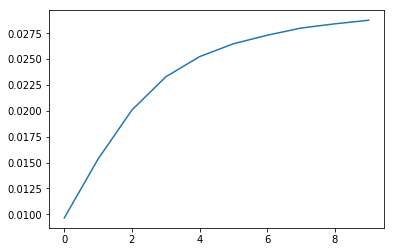

In [51]:
# plt.plot(incorrect_stack.mean(0))

## COM:

In [6]:
def get_recons_loss(model, latent, autoencoder, y_train_obs):
    y_train_pred = model(latent.detach())
    y_train_pred_reshape = y_train_pred.view(y_train_pred.size(0), -1,2)
    y_train_pred_recons = forward(autoencoder.decode, y_train_pred_reshape)
    mse = nn.MSELoss()(y_train_pred_recons, y_train_obs[:, :1])
    return mse

def quick_learn_recons(model, latent, autoencoder, y_train_obs, lr = 1e-3):
    model_train = deepcopy(model)
    optimizer = optim.Adam(model_train.parameters(), lr = lr)
    for i in range(5):
        optimizer.zero_grad()
        loss = get_recons_loss(model_train, latent, autoencoder, y_train_obs)
        loss.backward()
        optimizer.step()
    return model_train

def get_xx_yy(A):
    A = (A >= 0.5).float()
    num = (torch.linspace(0, 38,39)).unsqueeze(1)
    x = Variable(num.repeat(1,39)) * 0.025
    num = (torch.linspace(0, 38,39)).unsqueeze(0)
    y = Variable(num.repeat(39,1)) * 0.025
    xx = ((A * x).sum(-2).sum(-1) + 1e-8) / (A.sum(-2).sum(-1) + 1e-8)
    yy = ((A * y).sum(-2).sum(-1) + 1e-8) / (A.sum(-2).sum(-1) + 1e-8)
    return xx, yy

def get_distance(y_pred_recons, y_test_obs):
    xx, yy = get_xx_yy(y_pred_recons)
    xx0, yy0 = get_xx_yy(y_test_obs)
    distance = torch.sqrt((xx - xx0) ** 2 + (yy - yy0) ** 2)
    return distance.mean(0)


def get_recons_distance(task, num_gradient_steps = None):
    [[X_train_obs, y_train_obs], [X_test_obs, y_test_obs]], z_info = task
    X_train = forward(autoencoder.encode, X_train_obs)
    y_train = forward(autoencoder.encode, y_train_obs)
    X_test = forward(autoencoder.encode, X_test_obs)
    y_test = forward(autoencoder.encode, y_test_obs)

    latent = forward(autoencoder.encode, X_train_obs, )
    if num_gradient_steps is None:
        y_pred = master_model.get_predictions(X_test, X_train, y_train[:, :2], forward_steps = range(1,11))["y_pred"]
        y_pred_reshape = y_pred.view(y_pred.size(0), -1,2)
    else:
        new_model = quick_learn_recons(master_model.get_clone_net(X_train, y_train[:,:2]), latent, autoencoder, y_train_obs)
        y_pred_reshape = get_forward_pred(new_model, X_test, forward_steps=range(1,11))
    
    y_pred_recons = forward(autoencoder.decode, y_pred_reshape)
    distance = get_distance(y_pred_recons, y_test_obs)
    return distance

In [12]:
task = tasks_test[list(tasks_test.keys())[0]]
[[X_train_obs, y_train_obs], [X_test_obs, y_test_obs]], z_info = task

In [10]:
# 0 steps:
distance_list_meta = []
for _, task in tasks_test.items():
    distance_meta = get_recons_distance(task)
    distance_list_meta.append(distance_meta)

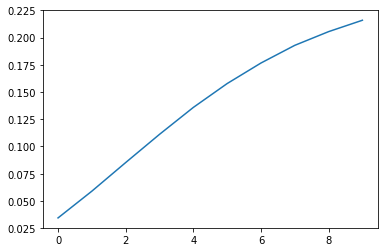

In [13]:
distance_list_meta = torch.stack(distance_list_meta)
distance_stack_meta = distance_list_meta
plt.plot(to_np_array(distance_stack_meta.mean(0)))
pickle.dump(distance_stack_meta, open("meta-distance.p", "wb"))

In [7]:
# 5 steps:
distance_list_meta = []
for _, task in tasks_test.items():
    distance_meta = get_recons_distance(task, num_gradient_steps = 5)
    distance_list_meta.append(distance_meta)

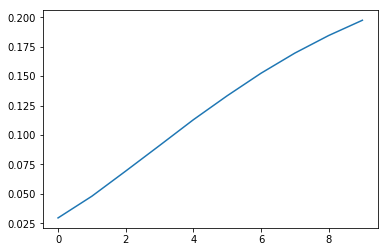

In [8]:
distance_list_meta5 = torch.stack(distance_list_meta)
distance_stack_meta5 = distance_list_meta5
plt.plot(to_np_array(distance_stack_meta5.mean(0)))
pickle.dump(distance_stack_meta5, open("meta-distance-5.p", "wb"))

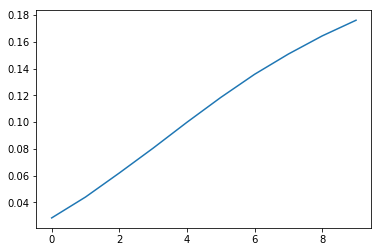

In [55]:
distance_list_meta5 = torch.stack(distance_list_meta)
distance_stack_meta5 = distance_list_meta5
plt.plot(to_np_array(distance_stack_meta5.mean(0)))
pickle.dump(distance_stack_meta5, open("meta-distance-5.p", "wb"))

In [20]:
# pickle.dump(mse_stack, open("wow-1.p", "wb"))

In [25]:
distance_stack_meta = pickle.load(open("meta-distance.p", "rb"))

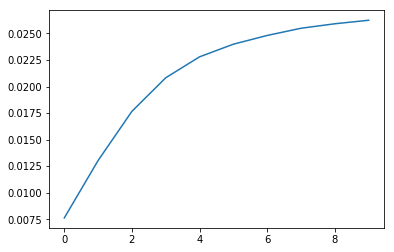

In [15]:
plt.plot(to_np_array(mse_stack.mean(0)))

## finetune:

In [3]:
task_id_list = [
# "latent-linear",
# "polynomial-3",
# "Legendre-3",
# "M-sawtooth",
# "M-sin",
# "M-Gaussian",
# "M-tanh",
# "M-softplus",
# "C-sin",
# "C-tanh",
# "bounce-states",
"bounce-images",
]

exp_id = "C-May18"
exp_mode = "meta"
exp_mode = "finetune"
# exp_mode = "oracle"
is_VAE = False
is_uncertainty_net = False
is_regulated_net = False
is_load_data = False
VAE_beta = 0.2
task_id_list = get_args(task_id_list, 3, type = "tuple")
if task_id_list[0] in ["C-sin", "C-tanh"]:
    statistics_output_neurons = 2 if task_id_list[0] == "C-sin" else 4
    z_size = 2 if task_id_list[0] == "C-sin" else 4
    num_shots = 10
    input_size = 1
    output_size = 1
    reg_amp = 1e-6
    forward_steps = [1]
    is_time_series = False
elif task_id_list[0] == "bounce-states":
    statistics_output_neurons = 8
    num_shots = 100
    z_size = 8
    input_size = 6
    output_size = 2
    reg_amp = 1e-8
    forward_steps = [1]
    is_time_series = True
elif task_id_list[0] == "bounce-images":
    statistics_output_neurons = 8
    num_shots = 100
    z_size = 8
    input_size = 6
    output_size = 2
    reg_amp = 1e-7
    forward_steps = [1]
    is_time_series = True
else:
    raise

is_autoencoder = True
max_forward_steps = 10

lr = 2e-4
num_train_tasks = 100
num_test_tasks = 100
batch_size_task = num_train_tasks
num_iter = 20000
pre_pooling_neurons = 200
num_context_neurons = 0
statistics_pooling = "max"
struct_param_pre_neurons = (100,3)
struct_param_gen_base_neurons = (60,3)
main_hidden_neurons = (40, 40, 40)
activation_gen = "leakyRelu"
activation_model = "leakyRelu"
optim_mode = "indi"
loss_core = "mse"
patience = 500
array_id = 0

exp_id = get_args(exp_id, 1)
exp_mode = get_args(exp_mode, 2)
statistics_output_neurons = get_args(statistics_output_neurons, 4, type = "int")
is_VAE = get_args(is_VAE, 5, type = "bool")
VAE_beta = get_args(VAE_beta, 6, type = "float")
lr = get_args(lr, 7, type = "float")
pre_pooling_neurons = get_args(pre_pooling_neurons, 8, type = "int")
num_context_neurons = get_args(num_context_neurons, 9, type = "int")
statistics_pooling = get_args(statistics_pooling, 10)
struct_param_pre_neurons = get_args(struct_param_pre_neurons, 11, "tuple")
struct_param_gen_base_neurons = get_args(struct_param_gen_base_neurons, 12, "tuple")
main_hidden_neurons = get_args(main_hidden_neurons, 13, "tuple")
reg_amp = get_args(reg_amp, 14, type = "float")
activation_gen = get_args(activation_gen, 15)
activation_model = get_args(activation_model, 16)
optim_mode = get_args(optim_mode, 17)
is_uncertainty_net = get_args(is_uncertainty_net, 18, "bool")
loss_core = get_args(loss_core, 19)
patience = get_args(patience, 20, "int")
forward_steps = get_args(forward_steps, 21, "tuple")
array_id = get_args(array_id, 22)

# Settings:
task_settings = {
    "xlim": (-5, 5),
    "num_examples": num_shots * 2,
    "test_size": 0.5,
}
isParallel = False
inspect_interval = 10
save_interval = 50
num_backwards = 1
is_oracle = (exp_mode == "oracle")
if is_oracle:
    input_size += z_size
    oracle_size = z_size
else:
    oracle_size = None
print("exp_mode: {0}".format(exp_mode))

# Obtain tasks:
assert len(task_id_list) == 1
dataset_filename = dataset_PATH + task_id_list[0] + "_{0}-shot.p".format(num_shots)
tasks = pickle.load(open(dataset_filename, "rb"))
tasks_train = get_torch_tasks(tasks["tasks_train"], task_id_list[0], num_forward_steps = forward_steps[-1], is_oracle = is_oracle, is_cuda = is_cuda)
tasks_test = get_torch_tasks(tasks["tasks_test"], task_id_list[0], start_id = num_train_tasks, num_tasks = num_test_tasks, num_forward_steps = 10, is_oracle = is_oracle, is_cuda = is_cuda)

# Obtain autoencoder:
aux_coeff = 0.3
if is_autoencoder:
    encoder_struct_param = [
        [32, "Conv2d", {"kernel_size": 3, "stride": 2}],
        [32, "Conv2d", {"kernel_size": 3, "stride": 2}],
        [32, "Conv2d", {"kernel_size": 3, "stride": 2}],
    ]
    settings = settings = {"activation": "relu"}
    decoder_struct_param = [
        [32, "ConvTranspose2d", {"kernel_size": 3, "stride": 2}],
        [32, "ConvTranspose2d", {"kernel_size": 3, "stride": 2}],
        [1, "ConvTranspose2d", {"kernel_size": 3, "stride": 2}],
    ]

    autoencoder = Conv_Autoencoder(
        encoder_struct_param,
        decoder_struct_param,
        enc_flatten_size = 512,
        latent_size = 2,
        settings = {"activation": "leakyReluFlat"},
        is_cuda = is_cuda,
    )
else:
    autoencoder = None
        
        
# Obtain nets:
all_keys = list(tasks_train.keys()) + list(tasks_test.keys())
data_record = {"loss": {key: [] for key in all_keys}, "loss_sampled": {key: [] for key in all_keys}, "mse": {key: [] for key in all_keys},
               "reg": {key: [] for key in all_keys}, "KLD": {key: [] for key in all_keys}}
reg_multiplier = np.linspace(0, 1, num_iter + 1) ** 2
if exp_mode in ["meta"]:
    struct_param_pre = [[struct_param_pre_neurons[0], "Simple_Layer", {}] for _ in range(struct_param_pre_neurons[1])]
    struct_param_pre.append([pre_pooling_neurons, "Simple_Layer", {"activation": "linear"}])
    struct_param_post = None
    struct_param_gen_base = [[struct_param_gen_base_neurons[0], "Simple_Layer", {}] for _ in range(struct_param_gen_base_neurons[1])]
    statistics_Net, generative_Net, generative_Net_logstd = get_nets(input_size = input_size, output_size = output_size, 
                                                                      target_size = len(forward_steps) * output_size, main_hidden_neurons = main_hidden_neurons,
                                                                      pre_pooling_neurons = pre_pooling_neurons, statistics_output_neurons = statistics_output_neurons, num_context_neurons = num_context_neurons,
                                                                      struct_param_pre = struct_param_pre,
                                                                      struct_param_gen_base = struct_param_gen_base,
                                                                      activation_statistics = activation_gen,
                                                                      activation_generative = activation_gen,
                                                                      activation_model = activation_model,
                                                                      statistics_pooling = statistics_pooling,
                                                                      isParallel = isParallel,
                                                                      is_VAE = is_VAE,
                                                                      is_uncertainty_net = is_uncertainty_net,
                                                                      is_cuda = is_cuda,
                                                                     )
    if is_regulated_net:
        struct_param_regulated_Net = [[num_neurons, "Simple_Layer", {}] for num_neurons in main_hidden_neurons]
        struct_param_regulated_Net.append([1, "Simple_Layer", {"activation": "linear"}])
        generative_Net = Net(input_size = input_size, struct_param = struct_param_regulated_Net, settings = {"activation": activation_model})
    master_model = Master_Model(statistics_Net, generative_Net, generative_Net_logstd, is_cuda = is_cuda)
    
    all_parameter_list = [statistics_Net.parameters(), generative_Net.parameters()]
    if is_uncertainty_net:
        all_parameter_list.append(generative_Net_logstd.parameters())
    if is_autoencoder:
        all_parameter_list.append(autoencoder.parameters())
    optimizer = optim.Adam(chain.from_iterable(all_parameter_list), lr = lr)
    reg_dict = {"statistics_Net": {"weight": reg_amp, "bias": reg_amp},
                "generative_Net": {"weight": reg_amp, "bias": reg_amp, "W_gen": reg_amp, "b_gen": reg_amp},
                "autoencoder": {"weight": 1e-7, "bias": 1e-7},
               }
    record_data(data_record, [struct_param_gen_base, struct_param_pre, struct_param_post], ["struct_param_gen_base", "struct_param_pre", "struct_param_post"])
    model = None

elif exp_mode in ["finetune", "oracle"]:
    struct_param_net = [[num_neurons, "Simple_Layer", {}] for num_neurons in main_hidden_neurons]
    struct_param_net.append([output_size, "Simple_Layer", {"activation": "linear"}])
    record_data(data_record, [struct_param_net], ["struct_param_net"])
    model = Net(input_size = input_size,
                  struct_param = struct_param_net,
                  settings = {"activation": activation_model},
                  is_cuda = is_cuda,
                 )
    reg_dict = {"net": {"weight": reg_amp, "bias": reg_amp},
                "autoencoder": {"weight": 1e-7, "bias": 1e-7},
               }
    all_parameter_list = [model.parameters()]
    if is_autoencoder:
        all_parameter_list.append(autoencoder.parameters())
    optimizer = optim.Adam(chain.from_iterable(all_parameter_list), lr = lr)
    statistics_Net = None
    generative_Net = None
    generative_Net_logstd = None
    master_model = None

exp_mode: finetune


In [4]:
filename = "Net_finetune_('bounce-images',)_input_6_(100,100)_stat_8_pre_200_pool_max_context_0_hid_(40, 40, 40)_(100, 3)_(60, 3)_VAE_False_0.2_uncer_False_lr_0.0001_reg_1e-06_actgen_leakyRelu_actmodel_leakyRelu_indi_core_mse_pat_500_May17-j"
dirname = variational_model_PATH + "/trained_models/wow-j/"

In [25]:
# info_dict = pickle.load(open(dirname + filename + "_info.p", "rb"))
# plot_data_record(info_dict["data_record"], idx = -1, is_VAE = is_VAE, tasks_train_keys = tasks_train.keys(), tasks_test_keys = tasks_test.keys())
# plot_data_record(info_dict["data_record"], is_VAE = is_VAE, tasks_train_keys = tasks_train.keys(), tasks_test_keys = tasks_test.keys())

In [5]:
idx = 2000
model.load_state_dict(torch.load(dirname + filename + "/conv-meta_model_{0}.p".format(idx)))
autoencoder.load_state_dict(torch.load(dirname + filename + "/conv-meta_autoencoder_{0}.p".format(idx)))

In [24]:
# task = tasks_test[list(tasks_test.keys())[0]]

In [7]:
# def get_recons_finetune(task):
#     [[X_train_obs, y_train_obs], [X_test_obs, y_test_obs]], z_info = task
#     X_train = forward(autoencoder.encode, X_train_obs)
#     y_train = forward(autoencoder.encode, y_train_obs)
#     X_test = forward(autoencoder.encode, X_test_obs)
#     y_test = forward(autoencoder.encode, y_test_obs)

#     latent = forward(autoencoder.encode, X_train_obs, )
#     y_pred_reshape = get_forward_pred(model, X_test, forward_steps = range(1,11), )
#     y_pred_recons = forward(autoencoder.decode, y_pred_reshape)
#     mse = ((y_test_obs - y_pred_recons) ** 2).mean(-1).mean(-1).mean(0)
#     return mse

In [8]:
# mse_list = []
# for _, task in tasks_test.items():
#     mse = get_recons_finetune(task)
#     mse_list.append(mse)

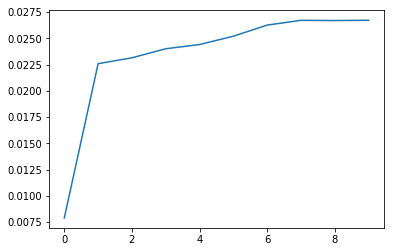

In [10]:
# mse_list = torch.stack(mse_list)
# mse_stack = mse_list
# plt.plot(to_np_array(mse_stack.mean(0)))

## Incorrect pixels:

In [9]:
# def get_recons_incorrect(task):
#     [[X_train_obs, y_train_obs], [X_test_obs, y_test_obs]], z_info = task
#     X_train = forward(autoencoder.encode, X_train_obs)
#     y_train = forward(autoencoder.encode, y_train_obs)
#     X_test = forward(autoencoder.encode, X_test_obs)
#     y_test = forward(autoencoder.encode, y_test_obs)

#     latent = forward(autoencoder.encode, X_train_obs, )
#     y_pred_reshape = get_forward_pred(model, X_test, forward_steps = range(1,11), )

#     y_pred_recons = forward(autoencoder.decode, y_pred_reshape)

#     hardened = to_np_array((y_pred_recons >=0.5)).astype(int)
#     y_test_obs_np = to_np_array(y_test_obs).astype(int)
#     incorrect = (hardened != y_test_obs_np).astype(int)
#     incorrect_core = incorrect.mean(-1).mean(-1).mean(0)
#     return incorrect_core

In [ ]:
# incorrect_list = []
# for _, task in tasks_test.items():
#     incorrect = get_recons_incorrect(task)
#     incorrect_list.append(incorrect)
# incorrect_list = np.stack(incorrect_list)
# incorrect_stack = incorrect_list
# plt.plot(incorrect_stack.mean(0))

## COM positions:

In [11]:
def get_recons_loss(model, latent, autoencoder, y_train_obs):
    y_train_pred = model(latent.detach())
    y_train_pred_reshape = y_train_pred.view(y_train_pred.size(0), -1,2)
    y_train_pred_recons = forward(autoencoder.decode, y_train_pred_reshape)
    mse = nn.MSELoss()(y_train_pred_recons, y_train_obs[:, :1])
    return mse

def quick_learn_recons(model, latent, autoencoder, y_train_obs, lr = 1e-3):
    model_train = deepcopy(model)
    optimizer = optim.Adam(model_train.parameters(), lr = lr)
    for i in range(5):
        optimizer.zero_grad()
        loss = get_recons_loss(model_train, latent, autoencoder, y_train_obs)
        loss.backward()
        optimizer.step()
    return model_train

def get_xx_yy(A):
    A = (A >= 0.5).float()
    num = (torch.linspace(0, 38,39)).unsqueeze(1)
    x = Variable(num.repeat(1,39)) * 0.025
    num = (torch.linspace(0, 38,39)).unsqueeze(0)
    y = Variable(num.repeat(39,1)) * 0.025
    xx = ((A * x).sum(-2).sum(-1) + 1e-8) / (A.sum(-2).sum(-1) + 1e-8)
    yy = ((A * y).sum(-2).sum(-1) + 1e-8) / (A.sum(-2).sum(-1) + 1e-8)
    return xx, yy

def get_distance(y_pred_recons, y_test_obs):
    xx, yy = get_xx_yy(y_pred_recons)
    xx0, yy0 = get_xx_yy(y_test_obs)
    distance = torch.sqrt((xx - xx0) ** 2 + (yy - yy0) ** 2)
    return distance.mean(0)


def get_recons_distance(task, num_gradient_steps = None):
    [[X_train_obs, y_train_obs], [X_test_obs, y_test_obs]], z_info = task
    X_train = forward(autoencoder.encode, X_train_obs)
    y_train = forward(autoencoder.encode, y_train_obs)
    X_test = forward(autoencoder.encode, X_test_obs)
    y_test = forward(autoencoder.encode, y_test_obs)

    if num_gradient_steps is None:
        y_pred_reshape = get_forward_pred(model, X_test, forward_steps = range(1,11), )
    else:
        new_model = quick_learn_recons(model, X_train, autoencoder, y_train_obs)
        y_pred_reshape = get_forward_pred(new_model, X_test, forward_steps=range(1,11))

    y_pred_recons = forward(autoencoder.decode, y_pred_reshape)
    distance = get_distance(y_pred_recons, y_test_obs)
    return distance

In [ ]:
# At 3000:

In [7]:
distance_list_finetune = []
for _, task in tasks_test.items():
    distance_finetune = get_recons_distance(task)
    distance_list_finetune.append(distance_finetune)

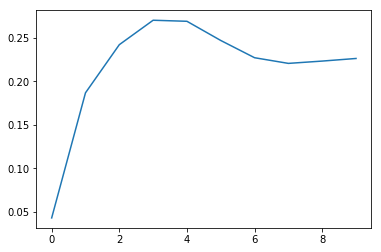

In [9]:
distance_list_finetune = torch.stack(distance_list_finetune)
distance_stack_finetune = distance_list_finetune
plt.plot(to_np_array(distance_stack_finetune.mean(0)))
pickle.dump(distance_stack_finetune, open("finetune-distance.p", "wb"))

In [ ]:
# 5 steps:
distance_list_finetune5 = []
for _, task in tasks_test.items():
    distance_finetune5 = get_recons_distance(task, num_gradient_steps = 5)
    distance_list_finetune5.append(distance_finetune5)

In [ ]:
distance_list_finetune5 = torch.stack(distance_list_finetune5)
distance_stack_finetune5 = distance_list_finetune5
plt.plot(to_np_array(distance_stack_finetune5.mean(0)))
pickle.dump(distance_stack_finetune5, open("finetune-distance-5.p", "wb"))

In [12]:
distance_stack_meta = pickle.load(open("meta-distance.p", "rb"))
distance_stack_meta5 = pickle.load(open("meta-distance-5.p", "rb"))
distance_stack_finetune = pickle.load(open("finetune-distance.p", "rb"))
distance_stack_finetune5 = pickle.load(open("finetune-distance-5.p", "rb"))
distance_stack_oracle = pickle.load(open("oracle-distance.p", "rb"))
distance_stack_oracle5 = pickle.load(open("oracle-distance5.p", "rb"))

In [13]:
loss_mean_meta = distance_stack_meta.mean(0)
loss_conf_meta = distance_stack_meta.std(0) * 1.96 / np.sqrt(100)
loss_mean_finetune = distance_stack_finetune.mean(0)
loss_conf_finetune = distance_stack_finetune.std(0) * 1.96 / np.sqrt(100)
loss_mean_meta2 = distance_stack_meta5.mean(0)
loss_conf_meta2 = distance_stack_meta5.std(0) * 1.96 / np.sqrt(100)
loss_mean_finetune2 = distance_stack_finetune5.mean(0)
loss_conf_finetune2= distance_stack_finetune5.std(0) * 1.96 / np.sqrt(100)
loss_mean_oracle = distance_stack_oracle.mean(0)
loss_conf_oracle = distance_stack_oracle.std(0) * 1.96 / np.sqrt(100)
loss_mean_oracle2 = distance_stack_oracle5.mean(0)
loss_conf_oracle2 = distance_stack_oracle5.std(0) * 1.96 / np.sqrt(100)

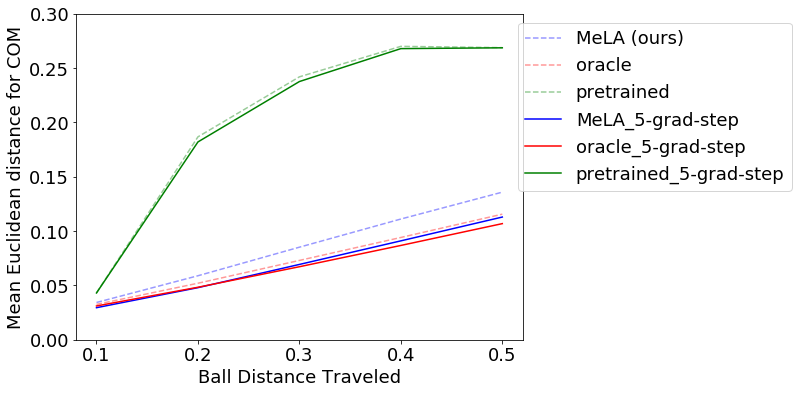

In [15]:
end = 5
x_axis = np.arange(1,end + 1) * 0.1

plt.figure(figsize = (8,6))
alpha10 = 0.4
alpha1 = 0.2
plt.plot(x_axis ,to_np_array(loss_mean_meta)[:end], color = "b", label = "MeLA (ours)", alpha = alpha10, linestyle = "--")
# plt.fill_between(x_axis,to_np_array(loss_mean_meta - loss_conf_meta)[:end], to_np_array(loss_mean_meta + loss_conf_meta)[:end], alpha = alpha1, color = "b")
plt.plot(x_axis,to_np_array(loss_mean_oracle)[:end], color = "r", label = "oracle", alpha = alpha10, linestyle = "--")
# plt.fill_between(x_axis,to_np_array(loss_mean_oracle - loss_conf_oracle)[:end], to_np_array(loss_mean_oracle + loss_conf_oracle)[:end], alpha = alpha1, color = "r")
plt.plot(x_axis,to_np_array(loss_mean_finetune)[:end], color = "g", label = "pretrained", alpha = alpha10, linestyle = "--")
# plt.fill_between(x_axis,to_np_array(loss_mean_finetune - loss_conf_finetune)[:end], to_np_array(loss_mean_finetune + loss_conf_finetune)[:end], alpha = alpha1, color = "g")
plt.legend(bbox_to_anchor = [0.9,0.5,.5,0.5], fontsize = 18)
plt.xlabel("Ball Distance Traveled", fontsize = 18)
plt.ylabel("Mean Euclidean distance for COM", fontsize = 18)
# ax = plt.gca()
# ax.tick_params(axis='both', labelsize = 18)
# plt.savefig("fig_bouncing_states_rollout.pdf",  bbox_inches='tight')
# plt.show()


end = 5
# plt.figure(figsize = (8,6))
plt.plot(x_axis ,to_np_array(loss_mean_meta2)[:end], color = "b", label = "MeLA_5-grad-step")
# plt.fill_between(x_axis ,to_np_array(loss_mean_meta2 - loss_conf_meta2)[:end], to_np_array(loss_mean_meta2 + loss_conf_meta2)[:end], alpha = 0.3, color = "b")
plt.plot(x_axis ,to_np_array(loss_mean_oracle2)[:end], color = "r", label = "oracle_5-grad-step")
# plt.fill_between(x_axis ,to_np_array(loss_mean_oracle2 - loss_conf_oracle2)[:end], to_np_array(loss_mean_oracle2 + loss_conf_oracle2)[:end], alpha = 0.3, color = "r")
plt.plot(x_axis ,to_np_array(loss_mean_finetune2)[:end], color = "g", label = "pretrained_5-grad-step")
# plt.fill_between(x_axis ,to_np_array(loss_mean_finetune2 - loss_conf_finetune2)[:end], to_np_array(loss_mean_finetune2 + loss_conf_finetune2)[:end], alpha = 0.3, color = "g")
plt.legend(bbox_to_anchor = [0.97,0.5,.5,0.5], fontsize = 18)
# plt.xlabel("Number of rollout steps", fontsize = 18)
# plt.ylabel("mean Euclidean distance", fontsize = 18)
ax = plt.gca()
plt.ylim([0,0.3])
ax.tick_params(axis='both', labelsize = 18)
plt.savefig("fig_bouncing_states_rollout.pdf",  bbox_inches='tight')
plt.show()

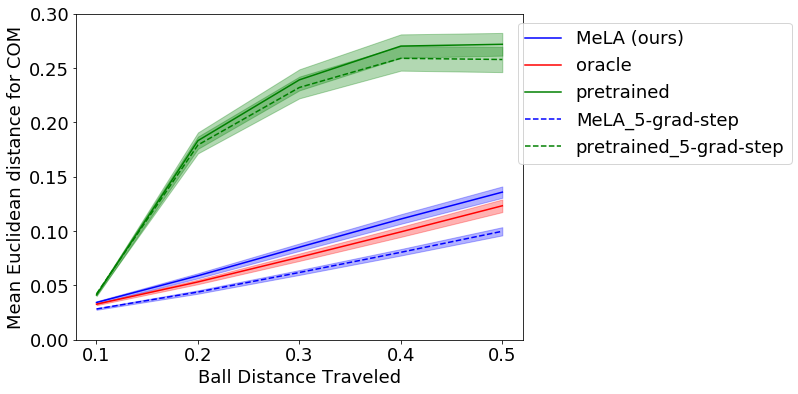

In [67]:
end = 5
x_axis = np.arange(1,end + 1) * 0.1
plt.figure(figsize = (8,6))
plt.plot(x_axis ,to_np_array(loss_mean_meta)[:end], color = "b", label = "MeLA (ours)")
plt.fill_between(x_axis,to_np_array(loss_mean_meta - loss_conf_meta)[:end], to_np_array(loss_mean_meta + loss_conf_meta)[:end], alpha = 0.3, color = "b")
plt.plot(x_axis,to_np_array(loss_mean_oracle)[:end], color = "r", label = "oracle")
plt.fill_between(x_axis,to_np_array(loss_mean_oracle - loss_conf_oracle)[:end], to_np_array(loss_mean_oracle + loss_conf_oracle)[:end], alpha = 0.3, color = "r")
plt.plot(x_axis,to_np_array(loss_mean_finetune)[:end], color = "g", label = "pretrained")
plt.fill_between(x_axis,to_np_array(loss_mean_finetune - loss_conf_finetune)[:end], to_np_array(loss_mean_finetune + loss_conf_finetune)[:end], alpha = 0.3, color = "g")
plt.legend(bbox_to_anchor = [0.9,0.5,.5,0.5], fontsize = 18)
plt.xlabel("Ball Distance Traveled", fontsize = 18)
plt.ylabel("Mean Euclidean distance for COM", fontsize = 18)

plt.plot(x_axis ,to_np_array(loss_mean_meta2)[:end], color = "b", label = "MeLA_5-grad-step", linestyle = "--")
plt.fill_between(x_axis ,to_np_array(loss_mean_meta2 - loss_conf_meta2)[:end], to_np_array(loss_mean_meta2 + loss_conf_meta2)[:end], alpha = 0.3, color = "b")
# plt.plot(x_axis ,to_np_array(loss_mean_oracle2)[:end], color = "r", label = "oracle_5-grad-step", linestyle = "--")
# plt.fill_between(x_axis ,to_np_array(loss_mean_oracle2 - loss_conf_oracle2)[:end], to_np_array(loss_mean_oracle2 + loss_conf_oracle2)[:end], alpha = 0.3, color = "r")
plt.plot(x_axis ,to_np_array(loss_mean_finetune2)[:end], color = "g", label = "pretrained_5-grad-step", linestyle = "--")
plt.fill_between(x_axis ,to_np_array(loss_mean_finetune2 - loss_conf_finetune2)[:end], to_np_array(loss_mean_finetune2 + loss_conf_finetune2)[:end], alpha = 0.3, color = "g")
plt.legend(bbox_to_anchor = [0.97,0.5,.5,0.5], fontsize = 18)

ax = plt.gca()
plt.ylim([0,0.3])
ax.tick_params(axis='both', labelsize = 18)
plt.savefig("fig_bouncing_states_rollout.pdf",  bbox_inches='tight')
plt.show()

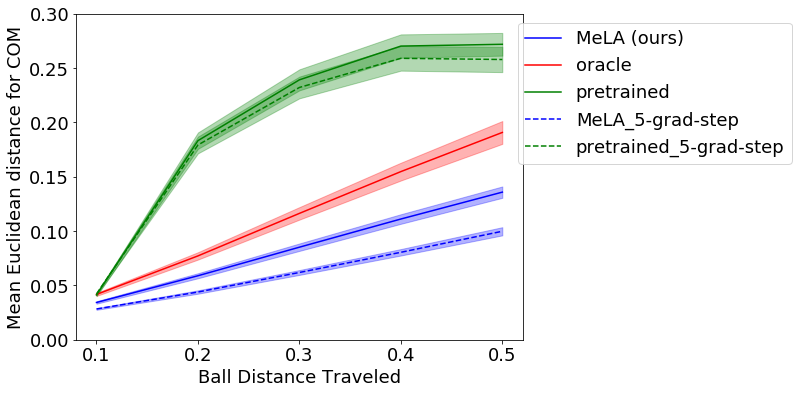

In [70]:
end = 5
x_axis = np.arange(1,end + 1) * 0.1
plt.figure(figsize = (8,6))
plt.plot(x_axis ,to_np_array(loss_mean_meta)[:end], color = "b", label = "MeLA (ours)")
plt.fill_between(x_axis,to_np_array(loss_mean_meta - loss_conf_meta)[:end], to_np_array(loss_mean_meta + loss_conf_meta)[:end], alpha = 0.3, color = "b")
plt.plot(x_axis,to_np_array(loss_mean_oracle)[:end], color = "r", label = "oracle")
plt.fill_between(x_axis,to_np_array(loss_mean_oracle - loss_conf_oracle)[:end], to_np_array(loss_mean_oracle + loss_conf_oracle)[:end], alpha = 0.3, color = "r")
plt.plot(x_axis,to_np_array(loss_mean_finetune)[:end], color = "g", label = "pretrained")
plt.fill_between(x_axis,to_np_array(loss_mean_finetune - loss_conf_finetune)[:end], to_np_array(loss_mean_finetune + loss_conf_finetune)[:end], alpha = 0.3, color = "g")
plt.legend(bbox_to_anchor = [0.9,0.5,.5,0.5], fontsize = 18)
plt.xlabel("Ball Distance Traveled", fontsize = 18)
plt.ylabel("Mean Euclidean distance for COM", fontsize = 18)

plt.plot(x_axis ,to_np_array(loss_mean_meta2)[:end], color = "b", label = "MeLA_5-grad-step", linestyle = "--")
plt.fill_between(x_axis ,to_np_array(loss_mean_meta2 - loss_conf_meta2)[:end], to_np_array(loss_mean_meta2 + loss_conf_meta2)[:end], alpha = 0.3, color = "b")
# plt.plot(x_axis ,to_np_array(loss_mean_oracle2)[:end], color = "r", label = "oracle_5-grad-step", linestyle = "--")
# plt.fill_between(x_axis ,to_np_array(loss_mean_oracle2 - loss_conf_oracle2)[:end], to_np_array(loss_mean_oracle2 + loss_conf_oracle2)[:end], alpha = 0.3, color = "r")
plt.plot(x_axis ,to_np_array(loss_mean_finetune2)[:end], color = "g", label = "pretrained_5-grad-step", linestyle = "--")
plt.fill_between(x_axis ,to_np_array(loss_mean_finetune2 - loss_conf_finetune2)[:end], to_np_array(loss_mean_finetune2 + loss_conf_finetune2)[:end], alpha = 0.3, color = "g")
plt.legend(bbox_to_anchor = [0.97,0.5,.5,0.5], fontsize = 18)

ax = plt.gca()
plt.ylim([0,0.3])
ax.tick_params(axis='both', labelsize = 18)
plt.savefig("fig_bouncing_states_rollout.pdf",  bbox_inches='tight')
plt.show()

In [13]:
loss_mean_meta = mse_stack.mean(0)

In [ ]:

end = 5

plt.plot(x_axis, t)

plt.plot(x_axis ,to_np_array(loss_mean_meta2)[:end], color = "b", label = "MeLA_5-grad-step", linestyle = "--")
plt.fill_between(x_axis ,to_np_array(loss_mean_meta2 - loss_conf_meta2)[:end], to_np_array(loss_mean_meta2 + loss_conf_meta2)[:end], alpha = 0.3, color = "b")
# plt.plot(x_axis ,to_np_array(loss_mean_oracle2)[:end], color = "r", label = "oracle_5-grad-step", linestyle = "--")
# plt.fill_between(x_axis ,to_np_array(loss_mean_oracle2 - loss_conf_oracle2)[:end], to_np_array(loss_mean_oracle2 + loss_conf_oracle2)[:end], alpha = 0.3, color = "r")
# plt.plot(x_axis ,to_np_array(loss_mean_finetune2)[:end], color = "g", label = "pretrained_5-grad-step", linestyle = "--")
# plt.fill_between(x_axis ,to_np_array(loss_mean_finetune2 - loss_conf_finetune2)[:end], to_np_array(loss_mean_finetune2 + loss_conf_finetune2)[:end], alpha = 0.3, color = "g")
# plt.legend(bbox_to_anchor = [0.97,0.5,.5,0.5], fontsize = 18)

## oracle:

In [3]:
task_id_list = [
# "latent-linear",
# "polynomial-3",
# "Legendre-3",
# "M-sawtooth",
# "M-sin",
# "M-Gaussian",
# "M-tanh",
# "M-softplus",
# "C-sin",
# "C-tanh",
# "bounce-states",
"bounce-images",
]

exp_id = "C-May18"
exp_mode = "meta"
exp_mode = "finetune"
exp_mode = "oracle"
is_VAE = False
is_uncertainty_net = False
is_regulated_net = False
is_load_data = False
VAE_beta = 0.2
task_id_list = get_args(task_id_list, 3, type = "tuple")
if task_id_list[0] in ["C-sin", "C-tanh"]:
    statistics_output_neurons = 2 if task_id_list[0] == "C-sin" else 4
    z_size = 2 if task_id_list[0] == "C-sin" else 4
    num_shots = 10
    input_size = 1
    output_size = 1
    reg_amp = 1e-6
    forward_steps = [1]
    is_time_series = False
elif task_id_list[0] == "bounce-states":
    statistics_output_neurons = 8
    num_shots = 100
    z_size = 8
    input_size = 6
    output_size = 2
    reg_amp = 1e-8
    forward_steps = [1]
    is_time_series = True
elif task_id_list[0] == "bounce-images":
    statistics_output_neurons = 8
    num_shots = 100
    z_size = 8
    input_size = 6
    output_size = 2
    reg_amp = 1e-7
    forward_steps = [1]
    is_time_series = True
else:
    raise

is_autoencoder = True
max_forward_steps = 10

lr = 2e-4
num_train_tasks = 100
num_test_tasks = 100
batch_size_task = num_train_tasks
num_iter = 20000
pre_pooling_neurons = 200
num_context_neurons = 0
statistics_pooling = "max"
struct_param_pre_neurons = (100,3)
struct_param_gen_base_neurons = (60,3)
main_hidden_neurons = (40, 40, 40)
activation_gen = "leakyRelu"
activation_model = "leakyRelu"
optim_mode = "indi"
loss_core = "mse"
patience = 500
array_id = 0

exp_id = get_args(exp_id, 1)
exp_mode = get_args(exp_mode, 2)
statistics_output_neurons = get_args(statistics_output_neurons, 4, type = "int")
is_VAE = get_args(is_VAE, 5, type = "bool")
VAE_beta = get_args(VAE_beta, 6, type = "float")
lr = get_args(lr, 7, type = "float")
pre_pooling_neurons = get_args(pre_pooling_neurons, 8, type = "int")
num_context_neurons = get_args(num_context_neurons, 9, type = "int")
statistics_pooling = get_args(statistics_pooling, 10)
struct_param_pre_neurons = get_args(struct_param_pre_neurons, 11, "tuple")
struct_param_gen_base_neurons = get_args(struct_param_gen_base_neurons, 12, "tuple")
main_hidden_neurons = get_args(main_hidden_neurons, 13, "tuple")
reg_amp = get_args(reg_amp, 14, type = "float")
activation_gen = get_args(activation_gen, 15)
activation_model = get_args(activation_model, 16)
optim_mode = get_args(optim_mode, 17)
is_uncertainty_net = get_args(is_uncertainty_net, 18, "bool")
loss_core = get_args(loss_core, 19)
patience = get_args(patience, 20, "int")
forward_steps = get_args(forward_steps, 21, "tuple")
array_id = get_args(array_id, 22)

# Settings:
task_settings = {
    "xlim": (-5, 5),
    "num_examples": num_shots * 2,
    "test_size": 0.5,
}
isParallel = False
inspect_interval = 10
save_interval = 50
num_backwards = 1
is_oracle = (exp_mode == "oracle")
if is_oracle:
    input_size += z_size
    oracle_size = z_size
else:
    oracle_size = None
print("exp_mode: {0}".format(exp_mode))

# Obtain tasks:
assert len(task_id_list) == 1
dataset_filename = dataset_PATH + task_id_list[0] + "_{0}-shot.p".format(num_shots)
tasks = pickle.load(open(dataset_filename, "rb"))
tasks_train = get_torch_tasks(tasks["tasks_train"], task_id_list[0], num_forward_steps = forward_steps[-1], is_oracle = is_oracle, is_cuda = is_cuda)
tasks_test = get_torch_tasks(tasks["tasks_test"], task_id_list[0], start_id = num_train_tasks, num_tasks = num_test_tasks, num_forward_steps = 10, is_oracle = is_oracle, is_cuda = is_cuda)

# Obtain autoencoder:
aux_coeff = 0.3
if is_autoencoder:
    encoder_struct_param = [
        [32, "Conv2d", {"kernel_size": 3, "stride": 2}],
        [32, "Conv2d", {"kernel_size": 3, "stride": 2}],
        [32, "Conv2d", {"kernel_size": 3, "stride": 2}],
    ]
    settings = settings = {"activation": "relu"}
    decoder_struct_param = [
        [32, "ConvTranspose2d", {"kernel_size": 3, "stride": 2}],
        [32, "ConvTranspose2d", {"kernel_size": 3, "stride": 2}],
        [1, "ConvTranspose2d", {"kernel_size": 3, "stride": 2}],
    ]

    autoencoder = Conv_Autoencoder(
        encoder_struct_param,
        decoder_struct_param,
        enc_flatten_size = 512,
        latent_size = 2,
        settings = {"activation": "leakyReluFlat"},
        is_cuda = is_cuda,
    )
else:
    autoencoder = None
        
        
# Obtain nets:
all_keys = list(tasks_train.keys()) + list(tasks_test.keys())
data_record = {"loss": {key: [] for key in all_keys}, "loss_sampled": {key: [] for key in all_keys}, "mse": {key: [] for key in all_keys},
               "reg": {key: [] for key in all_keys}, "KLD": {key: [] for key in all_keys}}
reg_multiplier = np.linspace(0, 1, num_iter + 1) ** 2
if exp_mode in ["meta"]:
    struct_param_pre = [[struct_param_pre_neurons[0], "Simple_Layer", {}] for _ in range(struct_param_pre_neurons[1])]
    struct_param_pre.append([pre_pooling_neurons, "Simple_Layer", {"activation": "linear"}])
    struct_param_post = None
    struct_param_gen_base = [[struct_param_gen_base_neurons[0], "Simple_Layer", {}] for _ in range(struct_param_gen_base_neurons[1])]
    statistics_Net, generative_Net, generative_Net_logstd = get_nets(input_size = input_size, output_size = output_size, 
                                                                      target_size = len(forward_steps) * output_size, main_hidden_neurons = main_hidden_neurons,
                                                                      pre_pooling_neurons = pre_pooling_neurons, statistics_output_neurons = statistics_output_neurons, num_context_neurons = num_context_neurons,
                                                                      struct_param_pre = struct_param_pre,
                                                                      struct_param_gen_base = struct_param_gen_base,
                                                                      activation_statistics = activation_gen,
                                                                      activation_generative = activation_gen,
                                                                      activation_model = activation_model,
                                                                      statistics_pooling = statistics_pooling,
                                                                      isParallel = isParallel,
                                                                      is_VAE = is_VAE,
                                                                      is_uncertainty_net = is_uncertainty_net,
                                                                      is_cuda = is_cuda,
                                                                     )
    if is_regulated_net:
        struct_param_regulated_Net = [[num_neurons, "Simple_Layer", {}] for num_neurons in main_hidden_neurons]
        struct_param_regulated_Net.append([1, "Simple_Layer", {"activation": "linear"}])
        generative_Net = Net(input_size = input_size, struct_param = struct_param_regulated_Net, settings = {"activation": activation_model})
    master_model = Master_Model(statistics_Net, generative_Net, generative_Net_logstd, is_cuda = is_cuda)
    
    all_parameter_list = [statistics_Net.parameters(), generative_Net.parameters()]
    if is_uncertainty_net:
        all_parameter_list.append(generative_Net_logstd.parameters())
    if is_autoencoder:
        all_parameter_list.append(autoencoder.parameters())
    optimizer = optim.Adam(chain.from_iterable(all_parameter_list), lr = lr)
    reg_dict = {"statistics_Net": {"weight": reg_amp, "bias": reg_amp},
                "generative_Net": {"weight": reg_amp, "bias": reg_amp, "W_gen": reg_amp, "b_gen": reg_amp},
                "autoencoder": {"weight": 1e-7, "bias": 1e-7},
               }
    record_data(data_record, [struct_param_gen_base, struct_param_pre, struct_param_post], ["struct_param_gen_base", "struct_param_pre", "struct_param_post"])
    model = None

elif exp_mode in ["finetune", "oracle"]:
    struct_param_net = [[num_neurons, "Simple_Layer", {}] for num_neurons in main_hidden_neurons]
    struct_param_net.append([output_size, "Simple_Layer", {"activation": "linear"}])
    record_data(data_record, [struct_param_net], ["struct_param_net"])
    model = Net(input_size = input_size,
                  struct_param = struct_param_net,
                  settings = {"activation": activation_model},
                  is_cuda = is_cuda,
                 )
    reg_dict = {"net": {"weight": reg_amp, "bias": reg_amp},
                "autoencoder": {"weight": 1e-7, "bias": 1e-7},
               }
    all_parameter_list = [model.parameters()]
    if is_autoencoder:
        all_parameter_list.append(autoencoder.parameters())
    optimizer = optim.Adam(chain.from_iterable(all_parameter_list), lr = lr)
    statistics_Net = None
    generative_Net = None
    generative_Net_logstd = None
    master_model = None

exp_mode: oracle


In [4]:
filename = "Net_oracle_('bounce-images',)_input_14_(100,100)_stat_8_pre_200_pool_max_context_0_hid_(40, 40, 40)_(100, 3)_(60, 3)_VAE_False_0.2_uncer_False_lr_0.0001_reg_1e-06_actgen_leakyRelu_actmodel_leakyRelu_indi_core_mse_pat_500_May17-oracle"
dirname = variational_model_PATH + "/trained_models/May17-oracle/"

In [5]:
idx = 4000
model.load_state_dict(torch.load(dirname + filename + "/conv-meta_model_{0}.p".format(idx)))
autoencoder.load_state_dict(torch.load(dirname + filename + "/conv-meta_autoencoder_{0}.p".format(idx)))

In [12]:
def get_recons_loss(model, latent, autoencoder, y_train_obs):
    y_train_pred = model(latent.detach())
    y_train_pred_reshape = y_train_pred.view(y_train_pred.size(0), -1,2)
    y_train_pred_recons = forward(autoencoder.decode, y_train_pred_reshape)
    mse = nn.MSELoss()(y_train_pred_recons, y_train_obs[:, :1])
    return mse

def quick_learn_recons(model, latent, autoencoder, y_train_obs, epochs, lr = 1e-3):
    model_train = deepcopy(model)
    optimizer = optim.Adam(model_train.parameters(), lr = lr)
    for i in range(epochs):
        optimizer.zero_grad()
        loss = get_recons_loss(model_train, latent, autoencoder, y_train_obs)
        loss.backward()
        optimizer.step()
    return model_train

def get_xx_yy(A):
    A = (A >= 0.5).float()
    num = (torch.linspace(0, 38,39)).unsqueeze(1)
    x = Variable(num.repeat(1,39)) * 0.025
    num = (torch.linspace(0, 38,39)).unsqueeze(0)
    y = Variable(num.repeat(39,1)) * 0.025
    xx = ((A * x).sum(-2).sum(-1) + 1e-8) / (A.sum(-2).sum(-1) + 1e-8)
    yy = ((A * y).sum(-2).sum(-1) + 1e-8) / (A.sum(-2).sum(-1) + 1e-8)
    return xx, yy

def get_distance(y_pred_recons, y_test_obs):
    xx, yy = get_xx_yy(y_pred_recons)
    xx0, yy0 = get_xx_yy(y_test_obs)
    distance = torch.sqrt((xx - xx0) ** 2 + (yy - yy0) ** 2)
    return distance.mean(0)


def get_recons_distance(task, num_gradient_steps = None, lr = 1e-3):
    [[X_train_obs, y_train_obs], [X_test_obs, y_test_obs]], z_info = task
    X_train = forward(autoencoder.encode, X_train_obs)
    y_train = forward(autoencoder.encode, y_train_obs)
    X_test = forward(autoencoder.encode, X_test_obs)
    y_test = forward(autoencoder.encode, y_test_obs)


    z_train = Variable(torch.FloatTensor(np.repeat(np.expand_dims(z_info["z"],0), len(X_train), 0)), requires_grad = False)
    z_test = Variable(torch.FloatTensor(np.repeat(np.expand_dims(z_info["z"],0), len(X_test), 0)), requires_grad = False)
    if is_cuda:
        z_train = z_train.cuda()
        z_test = z_test.cuda()
    X_train = torch.cat([X_train, z_train], 1)
    X_test = torch.cat([X_test, z_test], 1)
    if num_gradient_steps is None:
        y_pred_reshape = get_forward_pred(model, X_test, forward_steps = range(1,11), oracle_size = 8)
    else:
        new_model = quick_learn_recons(model, X_train, autoencoder, y_train_obs, epochs = num_gradient_steps, lr = lr)
        y_pred_reshape = get_forward_pred(new_model, X_test, forward_steps=range(1,11), oracle_size = 8)

    y_pred_recons = forward(autoencoder.decode, y_pred_reshape)
    distance = get_distance(y_pred_recons, y_test_obs)
    return distance

In [9]:
distance_list_oracle = []
for _, task in tasks_test.items():
    distance_oracle = get_recons_distance(task)
    distance_list_oracle.append(distance_oracle)

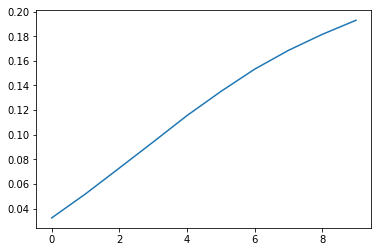

In [10]:
distance_list_oracle = torch.stack(distance_list_oracle)
distance_stack_oracle = distance_list_oracle
plt.plot(to_np_array(distance_stack_oracle.mean(0)))
pickle.dump(distance_stack_oracle, open("oracle-distance.p", "wb"))

In [30]:
tasks = pickle.load(open(dataset_filename, "rb"))
tasks_train = get_torch_tasks(tasks["tasks_train"], task_id_list[0], num_forward_steps = forward_steps[-1], is_oracle = is_oracle, is_cuda = is_cuda)
tasks_test = get_torch_tasks(tasks["tasks_test"], task_id_list[0], start_id = num_train_tasks, num_tasks = 100, num_forward_steps = 10, is_oracle = is_oracle, is_cuda = is_cuda)


## 5:

In [31]:
distance_list_oracle5 = []
for _, task in tasks_test.items():
    distance_oracle5 = get_recons_distance(task, num_gradient_steps = 5, lr =2e-4)
    distance_list_oracle5.append(distance_oracle5)

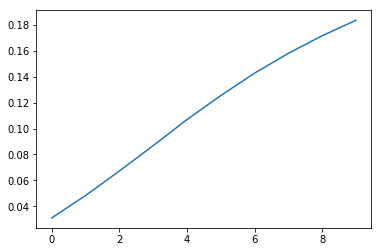

In [32]:
distance_list_oracle5 = torch.stack(distance_list_oracle5)
distance_stack_oracle5 = distance_list_oracle5
plt.plot(to_np_array(distance_stack_oracle5.mean(0)))
pickle.dump(distance_stack_oracle5, open("oracle-distance5.p", "wb"))